In [10]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load Rotten Tomatoes
rt = load_dataset("rotten_tomatoes")   # train/validation/test

def to_tf_dataset(hfds, text_key="text", label_key="label", batch_size=64, shuffle=False):
    # Convert HF columns to plain Python lists / numpy
    texts = list(hfds[text_key])
    labels = np.array(hfds[label_key], dtype=np.int32)

    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(20000, len(texts)), seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = to_tf_dataset(rt["train"], shuffle=True)
val_ds   = to_tf_dataset(rt["validation"], shuffle=False)
test_ds  = to_tf_dataset(rt["test"], shuffle=False)


In [2]:
def build_rnn_model(
    rnn_type="gru",
    vocab_size=20000,
    seq_len=50,
    embed_dim=128,
    rnn_units=128,
    dropout=0.3,
    lr=1e-3,
    bidirectional=False,
):
    # TextVectorization layer
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=seq_len
    )

    # Adapt vectorizer on training text only
    train_text_only = rt["train"]["text"]
    vectorizer.adapt(train_text_only)

    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
    x = vectorizer(inputs)
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(x)

    RNN = tf.keras.layers.GRU if rnn_type.lower() == "gru" else tf.keras.layers.LSTM
    rnn_layer = RNN(rnn_units)

    if bidirectional:
        x = tf.keras.layers.Bidirectional(rnn_layer)(x)
    else:
        x = rnn_layer(x)

    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [18]:
def train_one(config, epochs=10):
    model = build_rnn_model(**config)
    cb = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=2, restore_best_weights=True
        )
    ]
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cb, verbose=0)
    val_best = max(hist.history["val_accuracy"])
    return model, hist, val_best

grid = [
    {"rnn_type":"gru", "embed_dim":64,  "rnn_units":64,  "dropout":0.2, "lr":1e-3, "bidirectional":False},
    {"rnn_type":"lstm", "embed_dim":64, "rnn_units":64, "dropout":0.2, "lr":1e-3, "bidirectional":False},
    {"rnn_type":"gru", "embed_dim":128, "rnn_units":128, "dropout":0.3, "lr":1e-3, "bidirectional":False},
    {"rnn_type":"lstm","embed_dim":128, "rnn_units":128, "dropout":0.3, "lr":1e-3, "bidirectional":False},
    {"rnn_type":"gru", "embed_dim":128, "rnn_units":256, "dropout":0.4, "lr":1e-3, "bidirectional":False},
    {"rnn_type":"lstm","embed_dim":128, "rnn_units":256, "dropout":0.4, "lr":1e-3, "bidirectional":False},
    
]

results = []
histories = {}

for i, cfg in enumerate(grid):
    model, hist, val_best = train_one(cfg, epochs=12)
    results.append({**cfg, "val_best_acc": val_best, "params": model.count_params()})
    histories[i] = hist

df = pd.DataFrame(results).sort_values("val_best_acc", ascending=False)
df


,rnn_type,embed_dim,rnn_units,dropout,lr,bidirectional,val_best_acc,params
5,lstm,128,256,0.4,0.001,False,0.764540,2970753
0,gru,64,64,0.2,0.001,False,0.750469,1309185
4,gru,128,256,0.4,0.001,False,0.747655,2872961
3,lstm,128,128,0.3,0.001,False,0.747655,2699905
2,gru,128,128,0.3,0.001,False,0.745779,2667393
1,lstm,64,64,0.2,0.001,False,0.739212,1317249


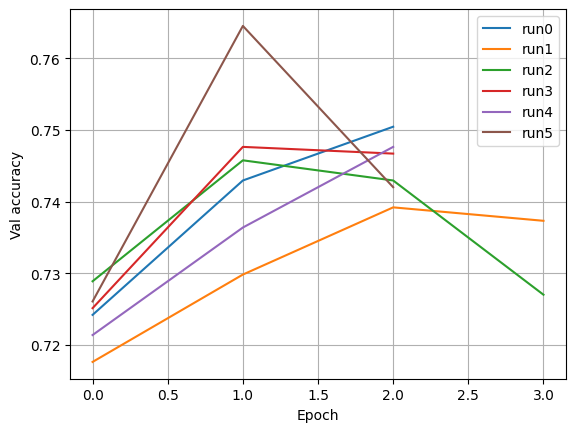

In [19]:
plt.figure()
for i, hist in histories.items():
    plt.plot(hist.history["val_accuracy"], label=f"run{i}")
plt.xlabel("Epoch")
plt.ylabel("Val accuracy")
plt.legend()
plt.grid(True)
plt.show()


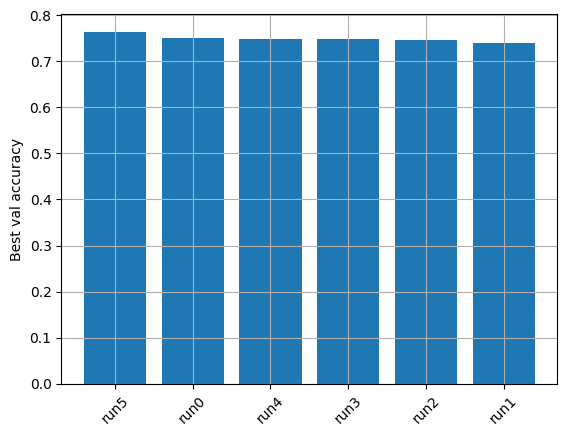

In [20]:
plt.figure()
plt.bar(range(len(df)), df["val_best_acc"].values)
plt.xticks(range(len(df)), [f"run{i}" for i in df.index], rotation=45)
plt.ylabel("Best val accuracy")
plt.grid(True)
plt.show()


In [28]:
best_cfg = df.iloc[0].drop(["val_best_acc","params"]).to_dict()
best_model = build_rnn_model(**best_cfg)
best_model.fit(train_ds, validation_data=val_ds, epochs=12,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)],
               verbose=0)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
test_acc


0.7757973670959473

In [29]:
uni_cfg = {**best_cfg, "bidirectional": False}
bi_cfg  = {**best_cfg, "bidirectional": True}

uni_model, uni_hist, uni_valbest = train_one(uni_cfg, epochs=12)
bi_model,  bi_hist,  bi_valbest  = train_one(bi_cfg,  epochs=12)

print("UNI best val acc:", uni_valbest, "params:", uni_model.count_params())
print("BI  best val acc:", bi_valbest,  "params:", bi_model.count_params())


UNI best val acc: 0.7532833218574524 params: 2970753
BI  best val acc: 0.7504690289497375 params: 3381377


In [27]:
examples = [
    "I thought it would be great, but it is not.",
    "The acting is strong, but the story collapses.",
    "What a masterpiece of boredom.",
    "It looks promising although it never delivers.",
    "it was an amazing movie with a thrilling plot and superb acting.",
    "it was an absolute waste of time and money."
]

def predict_texts(model, texts):
    probs = model.predict(tf.constant(texts), verbose=0).reshape(-1)
    return probs

uni_probs = predict_texts(uni_model, examples)
bi_probs  = predict_texts(bi_model, examples)

for t, up, bp in zip(examples, uni_probs, bi_probs):
    print(f"\nText: {t}")
    print(f"UNI prob(pos): {up:.3f}")
    print(f"BI  prob(pos): {bp:.3f}")



Text: I thought it would be great, but it is not.
UNI prob(pos): 0.505
BI  prob(pos): 0.383

Text: The acting is strong, but the story collapses.
UNI prob(pos): 0.490
BI  prob(pos): 0.290

Text: What a masterpiece of boredom.
UNI prob(pos): 0.737
BI  prob(pos): 0.699

Text: It looks promising although it never delivers.
UNI prob(pos): 0.481
BI  prob(pos): 0.396

Text: it was an amazing movie with a thrilling plot and superb acting.
UNI prob(pos): 0.522
BI  prob(pos): 0.708

Text: it was an absolute waste of time and money.
UNI prob(pos): 0.239
BI  prob(pos): 0.172


In [49]:
!pip install gensim

   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   -- ------------------------------------- 1.3/24.4 MB 10.8 MB/s eta 0:00:03
   ------ --------------------------------- 4.2/24.4 MB 11.5 MB/s eta 0:00:02
   ----------- ---------------------------- 6.8/24.4 MB 11.6 MB/s eta 0:00:02
   --------------- ------------------------ 9.4/24.4 MB 11.8 MB/s eta 0:00:02
   ------------------- -------------------- 11.8/24.4 MB 11.7 MB/s eta 0:00:02
   ----------------------- ---------------- 14.2/24.4 MB 11.6 MB/s eta 0:00:01
   --------------------------- ------------ 16.5/24.4 MB 11.5 MB/s eta 0:00:01
   ------------------------------ --------- 18.9/24.4 MB 11.7 MB/s eta 0:00:01
   ----------------------------------- ---- 21.5/24.4 MB 11.7 MB/s eta 0:00:01
   -------------------------------------- - 23.6/24.4 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 24.4/24.4 MB 11.3 MB/s  0:00:02

   ---------------------------------------- 0/2 [smart_open]
   ---

In [57]:
# import libraries
import numpy as np
from numpy.linalg import norm
from sklearn.decomposition import PCA
import gensim.downloader as api


# Load small pretrained GloVe
glove = api.load("glove-twitter-25")


# Get embedding + vocabulary from your trained model

def get_vectorizer(model):
    for layer in model.layers:
        if layer.__class__.__name__ == "TextVectorization":
            return layer
    raise ValueError("TextVectorization layer not found")

def get_embedding_matrix(model):
    for layer in model.layers:
        if "embedding" in layer.name.lower():
            return layer.get_weights()[0]
    raise ValueError("Embedding layer not found")

vectorizer = get_vectorizer(best_model)
vocab = vectorizer.get_vocabulary()
rt_embeddings = get_embedding_matrix(best_model)

def get_rt_vector(word):
    if word not in vocab:
        return None
    idx = vocab.index(word)
    return rt_embeddings[idx]


# Pick words to analyze

words = ["plot", "acting", "cheap", "affordable", "excellent", "waste",]

# Keep only words that exist in both spaces
words = [w for w in words if w in vocab and w in glove]
print("Using words:", words)

rt_vecs = np.stack([get_rt_vector(w) for w in words])
glove_vecs = np.stack([glove[w] for w in words])

print("RT dim:", rt_vecs.shape[1], "GloVe dim:", glove_vecs.shape[1])

# Build large shared vocabulary for PCA

shared = [w for w in vocab if w in glove][:2000]
rt_big = np.stack([get_rt_vector(w) for w in shared])
glove_big = np.stack([glove[w] for w in shared])


# Reduce both spaces to same dimension

k = 25   # same as glove-twitter-25
pca_rt = PCA(n_components=k, random_state=42).fit(rt_big)
pca_glove = PCA(n_components=k, random_state=42).fit(glove_big)

rt_vecs_k = pca_rt.transform(rt_vecs)
glove_vecs_k = pca_glove.transform(glove_vecs)


# Cosine similarity

def cosine(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-12))

pairs = [("plot","acting"), ("cheap","affordable"), ("plot","cheap"), ("acting","cheap"), ("affordable","excellent"), ("plot","excellent"), ("plot","waste"), ("acting","waste"), ("cheap","waste")]

for a,b in pairs:
    if a in words and b in words:
        i,j = words.index(a), words.index(b)
        print(f"\n{a} vs {b}")
        print("RT cosine:", round(cosine(rt_vecs_k[i], rt_vecs_k[j]),3))
        print("GloVe cosine:", round(cosine(glove_vecs_k[i], glove_vecs_k[j]),3))


# Nearest neighbors in Rotten Tomatoes embedding

rt_emb_k = pca_rt.transform(rt_embeddings)

def top_neighbors(word, k=10):
    idx = vocab.index(word)
    vec = rt_emb_k[idx]
    sims = []
    for i in range(len(vocab)):
        if i == idx:
            continue
        sims.append((vocab[i], cosine(vec, rt_emb_k[i])))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:k]

for w in words:
    print(f"\nNearest neighbors in Rotten Tomatoes embedding for '{w}':")
    for n,s in top_neighbors(w, 10):
        print(n, round(s,3))


Using words: ['plot', 'acting', 'cheap', 'excellent', 'waste']
RT dim: 128 GloVe dim: 25

plot vs acting
RT cosine: -0.041
GloVe cosine: -0.06

plot vs cheap
RT cosine: 0.31
GloVe cosine: -0.352

acting vs cheap
RT cosine: -0.138
GloVe cosine: -0.139

plot vs excellent
RT cosine: -0.187
GloVe cosine: -0.104

plot vs waste
RT cosine: 0.474
GloVe cosine: -0.156

acting vs waste
RT cosine: -0.288
GloVe cosine: 0.188

cheap vs waste
RT cosine: 0.567
GloVe cosine: 0.203

Nearest neighbors in Rotten Tomatoes embedding for 'plot':
shadyacs 0.735
tux 0.707
parlance 0.693
sloppily 0.688
frighten 0.687
doingitfor 0.678
effect 0.658
boyds 0.652
stylefree 0.651
theblanks 0.649

Nearest neighbors in Rotten Tomatoes embedding for 'acting':
wellmade 0.725
corcueras 0.634
scattershot 0.581
yearend 0.577
demise 0.572
sleeper 0.569
lieutenants 0.566
confidently 0.566
combining 0.565
purr 0.564

Nearest neighbors in Rotten Tomatoes embedding for 'cheap':
badness 0.794
block 0.767
sharpener 0.766
holidays